# Adult Income Dataset

Predict whether income exceeds $50K/yr based on census data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**Feature Engineering**

In [4]:
cats = ['workclass', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
conts = ['age', 'fnlwgt', 'capital.gain', 'capital.loss', 'hours.per.week']
target = 'income'

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
# unite categories ?, never-worked, without-pay
df['workclass'] = df['workclass'].apply(lambda x: x if x not in ['?', 'Without-pay', 'Never-worked'] else 'Without-pay')
print(df['workclass'].value_counts())

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
Without-pay          1857
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Name: workclass, dtype: int64


In [7]:
# unite caregories 'Married-AF-spouse' and 'Married-spouse-absent'
df['marital.status'] = df['marital.status'].apply(lambda x: x if x not in ['Married-AF-spouse', 'Married-spouse-absent'] else 'Married-spouse-absent')
print(df['marital.status'].value_counts())

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      441
Name: marital.status, dtype: int64


In [8]:
# unite all countries that are not USA
df['native.country'] = df['native.country'].apply(lambda x: x if x == 'United-States' else 'other')
print(df['native.country'].value_counts())

United-States    29170
other             3391
Name: native.country, dtype: int64


In [9]:
# apply category to target
df[target] = df[target].astype('category')

**Change values on DataFrame to its category codes**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       32561 non-null  object  
 2   fnlwgt          32561 non-null  int64   
 3   education       32561 non-null  object  
 4   education.num   32561 non-null  int64   
 5   marital.status  32561 non-null  object  
 6   occupation      32561 non-null  object  
 7   relationship    32561 non-null  object  
 8   race            32561 non-null  object  
 9   sex             32561 non-null  object  
 10  capital.gain    32561 non-null  int64   
 11  capital.loss    32561 non-null  int64   
 12  hours.per.week  32561 non-null  int64   
 13  native.country  32561 non-null  object  
 14  income          32561 non-null  category
dtypes: category(1), int64(6), object(8)
memory usage: 3.5+ MB


In [11]:
df = df.astype({x: 'category' for x in cats})
for col in cats:
    df[col] = df[col].cat.codes.values

df[target] = df[target].cat.codes.values

In [12]:
df.drop('education', inplace=True, axis=1)
df.head(10)

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,6,77053,8,5,0,1,4,0,0,4356,40,0,0
1,82,2,132870,8,5,4,1,4,0,0,4356,18,0,0
2,66,6,186061,9,5,0,4,2,0,0,4356,40,0,0
3,54,2,140359,3,0,7,4,4,0,0,3900,40,0,0
4,41,2,264663,9,4,10,3,4,0,0,3900,40,0,0
5,34,2,216864,8,0,8,4,4,0,0,3770,45,0,0
6,38,2,150601,5,4,1,4,4,1,0,3770,40,0,0
7,74,5,88638,15,3,10,2,4,0,0,3683,20,0,1
8,68,0,422013,8,0,10,1,4,0,0,3683,40,0,0
9,41,2,70037,9,3,3,4,4,1,0,3004,60,1,1


**Steps missing:**
1. Get train, test split dataloaders
2. Normalize continuous variables
3. Prepare embeddings
4. Define model
5. Train and choose hyperparameters
6. Test

In [13]:
# shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,21,2,230429,8,3,3,1,4,1,0,0,35,0,0
1,52,2,165998,9,1,7,0,4,1,0,0,40,0,0
2,32,2,251701,11,3,10,1,4,1,0,0,40,1,0
3,34,2,176648,8,0,1,1,2,1,0,0,42,0,0
4,22,6,196280,9,3,0,3,4,0,0,0,20,0,0
5,22,2,169188,8,3,4,3,4,0,0,0,20,0,0
6,33,2,174201,8,3,6,3,4,1,0,0,40,0,0
7,38,2,207202,8,1,7,0,4,1,0,0,48,0,1
8,42,2,208875,9,1,4,5,4,0,0,0,40,1,1
9,34,2,224358,5,3,8,4,2,0,0,0,40,0,0


In [14]:
# train test split
test_size = 0.2

X_train = df[[x for x in df.columns if x != 'income']][ : int(df.shape[0] * (1 - test_size))]
y_train = df['income'][ : int(df.shape[0] * (1 - test_size))]

X_test = df[[x for x in df.columns if x != 'income']][int(df.shape[0] * (1 - test_size)) : ]
y_test = df['income'][int(df.shape[0] * (1 - test_size)) : ]

print(f"Total data points: {df.shape[0]}")
print(f"Training data points: {X_train.shape[0]}")
print(f"Testing data points: {X_test.shape[0]}")

Total data points: 32561
Training data points: 26048
Testing data points: 6513


## Normalize continuous columns

In [15]:
print(f"Continuous columns: {conts}")

Continuous columns: ['age', 'fnlwgt', 'capital.gain', 'capital.loss', 'hours.per.week']


In [16]:
# normalize age column

age_max = X_train['age'].max()
age_min = X_train['age'].min()
print(f"Age range: {age_min} - {age_max}")

X_train['age'] = X_train['age'].apply(lambda x: (x - age_min) / (age_max - age_min))

Age range: 17 - 90


In [17]:
# normalize fnlwgt column

fnlwgt_max = X_train['fnlwgt'].max()
fnlwgt_min = X_train['fnlwgt'].min()
print(f"fnlwgt range: {fnlwgt_min} - {fnlwgt_max}")

X_train['fnlwgt'] = X_train['fnlwgt'].apply(lambda x: (x - fnlwgt_min) / (fnlwgt_max - fnlwgt_min))

fnlwgt range: 12285 - 1366120


In [18]:
# normalize capital.gain column

capital_max = X_train['capital.gain'].max()
capital_min = X_train['capital.gain'].min()
print(f"capital.gain range: {capital_min} - {capital_max}")

X_train['capital.gain'] = X_train['capital.gain'].apply(lambda x: (x - capital_min) / (capital_max - capital_min))

capital.gain range: 0 - 99999


In [19]:
# normalize capital.loss column

capital_loss_max = X_train['capital.loss'].max()
capital_loss_min = X_train['capital.loss'].min()
print(f"capital.loss range: {capital_loss_min} - {capital_loss_max}")

X_train['capital.loss'] = X_train['capital.loss'].apply(lambda x: (x - capital_loss_min) / (capital_loss_max - capital_loss_min))

capital.loss range: 0 - 4356


In [20]:
# normalize hours.per.week column

hours_per_week_max = X_train['hours.per.week'].max()
hours_per_week_min = X_train['hours.per.week'].min()
print(f"hours.per.week range: {hours_per_week_min} - {hours_per_week_max}")

X_train['hours.per.week'] = X_train['hours.per.week'].apply(lambda x: (x - hours_per_week_min) / (hours_per_week_max - hours_per_week_min))

hours.per.week range: 1 - 99


In [21]:
# normalize test columns with values from train columns
X_test['age'] = X_test['age'].apply(lambda x: (x - age_min) / (age_max - age_min))
X_test['fnlwgt'] = X_test['fnlwgt'].apply(lambda x: (x - fnlwgt_min) / (fnlwgt_max - fnlwgt_min))
X_test['capital.gain'] = X_test['capital.gain'].apply(lambda x: (x - capital_min) / (capital_max - capital_min))
X_test['capital.loss'] = X_test['capital.loss'].apply(lambda x: (x - capital_loss_min) / (capital_loss_max - capital_loss_min))
X_test['hours.per.week'] = X_test['hours.per.week'].apply(lambda x: (x - hours_per_week_min) / (hours_per_week_max - hours_per_week_min))

## Create dataloaders

In [22]:
batch_size = 256

train_categorical_dataloader = DataLoader(
    TensorDataset(
        torch.Tensor(X_train[cats].to_numpy())
    ),
    batch_size=batch_size
)
train_continuous_dataloader = DataLoader(
    TensorDataset(
        torch.Tensor(X_train[conts].to_numpy())
    ),
    batch_size=batch_size
)
train_target_dataloader = DataLoader(
    TensorDataset(
        torch.Tensor(y_train.to_numpy())
    ),
    batch_size=batch_size
)

test_categorical_dataloader = DataLoader(
    TensorDataset(
        torch.Tensor(X_test[cats].to_numpy())
    ),
    batch_size=batch_size
)
test_continuous_dataloader = DataLoader(
    TensorDataset(
        torch.Tensor(X_test[conts].to_numpy())
    ),
    batch_size=batch_size
)
test_target_dataloader = DataLoader(
    TensorDataset(
        torch.Tensor(y_test.to_numpy())
    ),
    batch_size=batch_size
)


## Prepare embeddings sizes

In [23]:
embeddings_sizes = []

for cat in cats:
    categories = len(df[cat].unique())
    embedding_size = (categories + 1) // 2
    embeddings_sizes.append((categories, embedding_size))

print(embeddings_sizes)

[(7, 4), (16, 8), (6, 3), (15, 8), (6, 3), (5, 3), (2, 1), (2, 1)]


## Define the model class

In [24]:
class Model(nn.Module):

    def __init__(self, embedding_sizes, n_continuous, p_dropout = 0.4):
        super().__init__()

        # embedding layers
        self.embeddings = nn.ModuleList([nn.Embedding(num_embeddings, embedding_dim) for num_embeddings, embedding_dim in embedding_sizes])
        self.embeddings_dropout = nn.Dropout(p_dropout)
        
        # normalize continuous
        self.normalize_continuous = nn.BatchNorm1d(n_continuous)

        # linear FC layers
        number_embeddings = sum([number_embeddings_per_column for _, number_embeddings_per_column in embedding_sizes])
        in_features = number_embeddings + n_continuous
        layer_list = [
            nn.Linear(in_features=in_features, out_features=64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=p_dropout),
            nn.BatchNorm1d(64),

            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=p_dropout),
            nn.BatchNorm1d(128),

            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=p_dropout),
            nn.BatchNorm1d(32),
            
            nn.Linear(in_features=32, out_features=2),
        ]
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x_categorical, x_continuous):

        x_categorical_tensor = x_categorical[0].int()
        x_continuous_tensor = x_continuous[0]

        # process embeddings
        embeddings = []
        for i, embedding_layer in enumerate(self.embeddings):
            embeddings.append(embedding_layer(x_categorical_tensor[:, i]))
        x_cat = torch.cat(embeddings, dim=1)
        x_cat = self.embeddings_dropout(x_cat)

        # process continuous
        x_cont = self.normalize_continuous(x_continuous_tensor)

        # concatenate all inputs
        x = torch.cat([x_cat, x_cont], dim=1)

        # apply layers
        return self.layers(x)

        

In [25]:
model = Model(embedding_sizes=embeddings_sizes, n_continuous=len(conts))
model

Model(
  (embeddings): ModuleList(
    (0): Embedding(7, 4)
    (1): Embedding(16, 8)
    (2): Embedding(6, 3)
    (3): Embedding(15, 8)
    (4): Embedding(6, 3)
    (5): Embedding(5, 3)
    (6): Embedding(2, 1)
    (7): Embedding(2, 1)
  )
  (embeddings_dropout): Dropout(p=0.4, inplace=False)
  (normalize_continuous): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=36, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=128, out_features=32, bias=True)
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): Bat

## Define hyperparameters

In [26]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0006)
criterion = nn.CrossEntropyLoss()

## Train

In [27]:
epochs = 30
losses = []

for epoch in range(epochs):

    for i, (x_cat, x_cont, y) in enumerate(zip(train_categorical_dataloader, train_continuous_dataloader, train_target_dataloader)):

        # convert list to tensor
        y = y[0].float().reshape(-1, 1)

        y_pred = model(x_cat, x_cont)
        loss = criterion(y_pred, y.flatten().long())

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    losses.append(loss.item())
    print(f"epoch: {epoch}      loss: {loss}")

epoch: 0      loss: 0.5412001013755798
epoch: 1      loss: 0.4505203664302826
epoch: 2      loss: 0.4241335093975067
epoch: 3      loss: 0.3743450343608856
epoch: 4      loss: 0.4140559434890747
epoch: 5      loss: 0.367561936378479
epoch: 6      loss: 0.3541419208049774
epoch: 7      loss: 0.387538880109787
epoch: 8      loss: 0.3966614305973053
epoch: 9      loss: 0.33854809403419495
epoch: 10      loss: 0.39538872241973877
epoch: 11      loss: 0.3681511878967285
epoch: 12      loss: 0.39696964621543884
epoch: 13      loss: 0.369655966758728
epoch: 14      loss: 0.3736598491668701
epoch: 15      loss: 0.334595650434494
epoch: 16      loss: 0.34281864762306213
epoch: 17      loss: 0.35955727100372314
epoch: 18      loss: 0.38014745712280273
epoch: 19      loss: 0.3290325701236725
epoch: 20      loss: 0.3347879648208618
epoch: 21      loss: 0.3290638327598572
epoch: 22      loss: 0.32478833198547363
epoch: 23      loss: 0.34755146503448486
epoch: 24      loss: 0.33262279629707336
epoch

Text(0.5, 1.0, 'Training loss: 0.349')

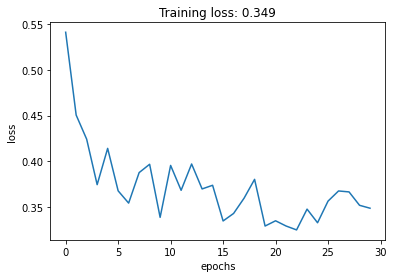

In [28]:
plt.plot(range(len(losses)), losses)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title(f"Training loss: {round(losses[-1], 3)}")

## Evaluate accuracy on test set

In [29]:
corrects = 0

with torch.no_grad():
    for i, (x_cat, x_cont, y) in enumerate(zip(test_categorical_dataloader, test_continuous_dataloader, test_target_dataloader)):

        # convert list to tensor
        y = y[0].float().reshape(-1, 1)

        # predict the value
        y_val = model(x_cat, x_cont)

        # sum to corrects to calculate accuracy
        for y_val_point, y_point in zip(y_val.flatten(), y.flatten()):
            if y_val_point.argmax() == y_point.item():
                corrects += 1


print(f"Corrects: {corrects}/{X_test.shape[0]}     [{round(corrects/X_test.shape[0], 3) * 100}%]")

Corrects: 4968/6513     [76.3%]


In [31]:
name = 'custom'
torch.save(model.state_dict, f'../models/{name}.pt')